In [262]:
import os
import time
import itertools

from torchvision.transforms import v2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 


%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
def data_split(test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds, val_prop=0.1):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    assert 0 <= fold_idx < nfolds, f'fold_idx was set to {fold_idx} but must be in the range [0, {nfolds - 1} = (nfolds - 1)]'
    batch_data = dsl[dsl['batch_id_x'] == batch_id]
    if nfolds == 1:
        val_prop = val_prop
    else:
        val_prop = 1 / nfolds
    
    if test_module_ids is not None:
        test_data = batch_data[batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        train_data = batch_data[~batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        assert len(test_data) > 0 and len(train_data) > 0, 'At least one module_id in test_modules={test_module_ids} is invalid.'        
        test_idx = test_data.index.values

        ntrain = len(train_data)
        nval = int(ntrain * val_prop)
        
        # nbdd = int((ntrain - nval) * boundary_prop / 2)
        left_val_idx = int(nval * fold_idx)
        right_val_idx = int(nval * (fold_idx + 1))
        
        val_idx = train_data[left_val_idx: right_val_idx].index.values
        
        train_idx = np.append(
            train_data[:max(0, left_val_idx - nval)].index.values,
            train_data[right_val_idx + nval:].index.values
        )
    else:
        batch_data = batch_data.sort_values(by = 'frame_unix_t')
        test_split = int(len(batch_data) * test_prop)
        ntrain = len(batch_data) - test_split
        val_split = int(ntrain * val_prop)
        boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
        
        test_idx = batch_data[:test_split].index.values
        val_idx = batch_data[test_split: test_split + val_split].index.values
        train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    assert len(set(val_idx).intersection(set(train_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'
    assert len(set(train_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between train_idx and train_idx'
    assert len(set(val_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'

    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, boundary_prop=0.2, test_module_ids=None, fold_idx=0, nfolds=5):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in dsl['batch_id_x'].unique():
        test_idx, val_idx, train_idx = data_split(
            test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds
        )
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices


def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

def preview_frames(data_loader, frame_time=0.01):
    try:
        for X, Y in data_loader:
            for img in X:
                plt.imshow(img.reshape((32,32)), vmin=-2, vmax=2, cmap='icefire')
                plt.show()
                plt.close()
                time.sleep(frame_time)
                display.clear_output(wait=True)
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

# def get_dataloader_preview(data_loader, stride, title, frame_time=0.01, ax=None):
#     # try:
#     stacked = None
#     # k = 0
#     for X, Y in data_loader:
#         curr = X[::stride]
#         if len(curr) != batch_size // stride:
#             continue
#         curr = curr.reshape(32 * batch_size // stride, 32).T
#         # plt.imshow(curr, vmin=-2, vmax=2, cmap='icefire')
#         # plt.show()
#         # plt.close()
#         # time.sleep(0.5)
#         # display.clear_output(wait=True)
#         if stacked is None:
#             stacked = curr
#         else:
#             stacked = np.concatenate((stacked, curr), axis=0)
#         # k += 1
#         # if k > 3:
#             # break
#     ax.imshow(stacked, vmin=-2, vmax=2, cmap='icefire')
#     ax.set_title(title)
#     # except KeyboardInterrupt:
#     #     plt.close()
#     # finally:
#     #     plt.close()
#     #     gc.collect()


def get_dataset_preview(dataset, idxs, title, nrows, ncols, ax, idx_to_plot=0):
    imgs = np.zeros((nrows * 32, ncols * 32))
    sample_idxs = np.random.choice(idxs, nrows * ncols, replace=False)
    if len(sample_idxs) < nrows * ncols:
        return 'Not enough data'
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    ax.imshow(imgs, vmin=-1, vmax=1, cmap='icefire')
    ax.set_title(title)

def get_pixel_dist(dataset, idxs, title, nsamples, ax, idx_to_plot=0):
    imgs = np.empty((nsamples, 32, 32))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    if len(sample_idxs) < nsamples:
        return 'Not enough data'
    for i, idx in enumerate(sample_idxs):
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[i] = curr.numpy()
    sns.histplot(imgs.ravel(), stat='density', ax=ax, label=idx_to_plot, binrange=[-1,1])
    ax.legend()
    ax.set_title(title)


def get_cloudy_stats(data, idx):
    filtered_data = data.iloc[idx]
    clear_data = filtered_data.loc[filtered_data['label'] == 'clear_night_sky']
    cloudy_data = filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy']
    prop_clear = len(clear_data) / len(filtered_data)
    prop_cloudy = len(cloudy_data) / len(filtered_data)
    return len(cloudy_data), prop_cloudy


def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    ncloudy, prop_cloudy = get_cloudy_stats(data, idx)
    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    print(f'Percent cloudy (in {name}) = {100 * prop_cloudy:.3f}% ({ncloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')

def get_fold_class_dists(nfolds):
    df = pd.DataFrame(columns=['Fold_idx', 'dataset', 'ncloudy', 'cloudy_prop', 'size'])
    for fold_idx in range(nfolds):
        # Get data splits
        test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
            test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
        )
        print(f'Fold {fold_idx}')
        for idxs, name in zip([test_idx, val_idx, train_idx], ['test', 'val', 'train']):
            ncloudy, cloudy_prop = get_cloudy_stats(dsl, idxs)
            row = [fold_idx, name, ncloudy, cloudy_prop, len(idxs)]
            df.loc[len(df)] = row
            print('\t', end='')
            print_class_dist(dsl, idxs, name)
    print_class_dist(dsl, dsl.index, 'overall')

In [299]:
# Creating the datasets
mean = [7.4, 0, 0]
std = [10, 50, 75]

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomRotation(90, expand=False),
    v2.Normalize(mean=mean, std=std),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=mean, std=std),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float),
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

dsl = train_labeled_data.dsl_df
dataset_size = len(dsl)

In [327]:
test_prop = 0.3
nfolds = 6
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 64

test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=0, nfolds=nfolds
)

# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]


print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))
test_df = get_fold_class_dists(nfolds)

test_prop (of dataset) = 33.34%
train_prop (of trainset)= 80.06%
val_prop (of trainset) = 19.94%
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.744% (524 / 975); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.066% (2195 / 3915); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.19938650306748465
0
Fold 0
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 53.744% (524 / 975); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 56.066% (2195 / 3915); Unique module_ids: [1, 254]
Fold 1
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 53.846% (525 / 975); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 56.463% (1660 / 2940); Unique module_ids: [1, 254]
Fold 2
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6


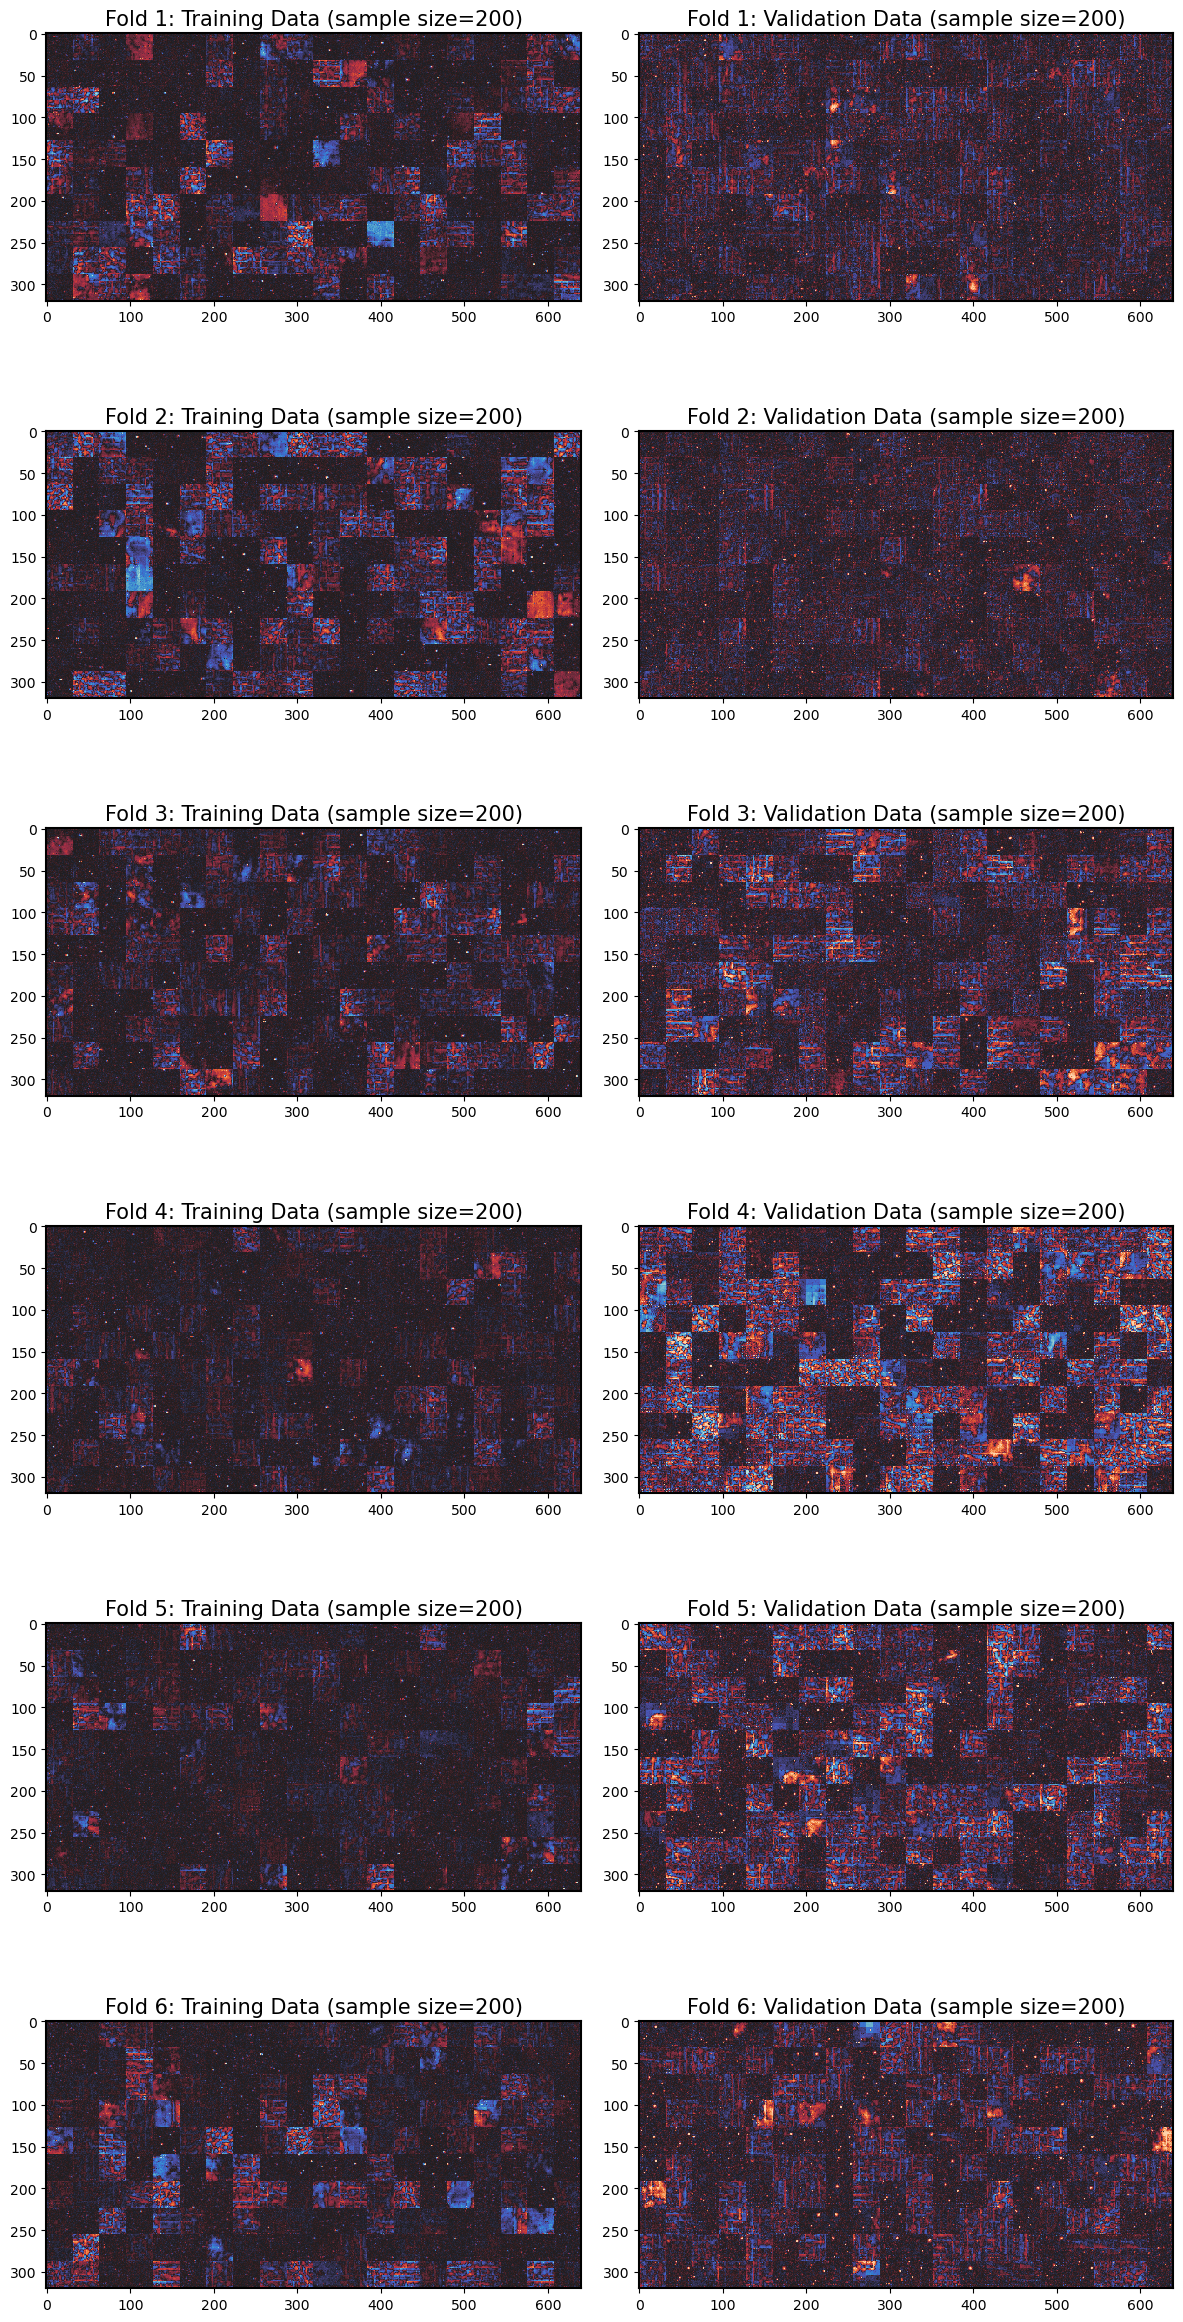

In [295]:
fig, axs = plt.subplots(nfolds, 2, figsize=(12, 24))
fig.tight_layout()
for fold_idx in range(nfolds):
    # Get data splits
    test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
        test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
    )
    print(f'Fold {fold_idx + 1}')
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)
    # train_loader = torch.utils.data.DataLoader(
    #           dataset=train_labeled_data,
    #           batch_size=batch_size,
    #           sampler=torch.utils.data.SubsetRandomSampler(train_idx[::5])
    # )  
    # val_loader = torch.utils.data.DataLoader(
    #   dataset=test_labeled_data,
    #   batch_size=batch_size,
    #   sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
    # )
    
    # get_dataset_preview(train_loader, stride=1, title=f'Fold {fold_idx} Training Data Sample', ax=axs[fold_idx][0])
    # get_dataset_preview(val_loader, stride=1, title=f'Fold {fold_idx} Validation Data Sample', ax=axs[fold_idx][1])
    nrows, ncols = 10, 20
    
    # get_pixel_dist(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     nsamples=200, ax=axs[fold_idx][0], idx_to_plot=2
    # )
    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     nsamples=200, ax=axs[fold_idx][1], idx_to_plot=1
    # )
    
    get_dataset_preview(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        nrows=nrows, ncols=ncols, ax=axs[fold_idx][0], idx_to_plot=2
    )
    get_dataset_preview(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        nrows=nrows, ncols=ncols, ax=axs[fold_idx][1], idx_to_plot=1
    )
plt.show(fig)
plt.close()

In [328]:
learning_rate = 0.001
weight_decay = 1e-5
epochs = 15
# nfolds = 8
gamma = 0.9
def do_cross_validation(test_prop, nfolds):
    test_loader = None
    validation_accuracies = []
    trainers = []
    dsl = train_labeled_data.dsl_df
    try:
        for fold_idx in range(nfolds):
            # Get data splits
            test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
                test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
            )
            # Make dataloaders
            train_loader = torch.utils.data.DataLoader(
              dataset=train_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.SubsetRandomSampler(train_idx)
            )
            
            val_loader = torch.utils.data.DataLoader(
              dataset=test_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
            )
            if test_loader is None:
                test_loader = torch.utils.data.DataLoader(
                  dataset=test_labeled_data,
                  batch_size=batch_size,
                  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
                )

            # Create model
            model = CloudDetection()
            # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            loss_fn = nn.CrossEntropyLoss()
            
            trainer = Trainer(
                model, optimizer, loss_fn, train_loader, val_loader,
                epochs=epochs, gamma=gamma, do_summary=False,
                # img_type=img_type
            )
            print(f'Doing Fold {fold_idx + 1} of {nfolds}')
            trainer.train(make_train_logs=True, write_plots=False, fold_idx=fold_idx + 1)

            # Print stats
            print(f'Fold {fold_idx + 1} Class Stats')
            print_class_dist(dsl, test_idx, 'test')
            print_class_dist(dsl, val_idx, 'val')
            print_class_dist(dsl, train_idx, 'train')
            print_class_dist(dsl, dsl.index, 'overall')

            data_fig, data_axs = plt.subplots(1, 2, figsize=(12,24))
            data_fig.tight_layout()
            nrows, ncols = 15, 30
            get_dataset_preview(
                train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
                nrows=nrows, ncols=ncols, ax=data_axs[0]
            )
            get_dataset_preview(
                test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
                nrows=nrows, ncols=ncols, ax=data_axs[1]
            )
            plt.show(data_fig)
            plt.close(data_fig)
            
            average_validation_accuracies_in_last_5_epochs = trainer.training_log['val']['acc'][-5:]
            validation_accuracies.append(average_validation_accuracies_in_last_5_epochs)
    
            # Cleanup
            trainer.model.to('cpu')
            trainers.append(trainer)
    except Exception as e:
        raise e
    finally:
        print(f'Average validation accuracy: {np.mean(validation_accuracies)}')
        return validation_accuracies, trainers

Doing Fold 1 of 6


Epoch 1


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.6511,  acc = 495/975 (50.77%) 
      Train: 	loss = 0.5849,  acc = 2896/3915 (73.97%)


Epoch 2


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.7188,  acc = 540/975 (55.38%) 
      Train: 	loss = 0.4941,  acc = 3185/3915 (81.35%)


Epoch 3


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.6428,  acc = 556/975 (57.03%) 
      Train: 	loss = 0.4207,  acc = 3294/3915 (84.14%)


Epoch 4


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.6220,  acc = 593/975 (60.82%) 
      Train: 	loss = 0.4476,  acc = 3423/3915 (87.43%)


Epoch 5


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.6340,  acc = 589/975 (60.41%) 
      Train: 	loss = 0.4412,  acc = 3421/3915 (87.38%)


Epoch 6


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.6535,  acc = 579/975 (59.38%) 
      Train: 	loss = 0.4710,  acc = 3384/3915 (86.44%)


Epoch 7


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5758,  acc = 706/975 (72.41%) 
      Train: 	loss = 0.4268,  acc = 3594/3915 (91.80%)


Epoch 8


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5736,  acc = 679/975 (69.64%) 
      Train: 	loss = 0.4101,  acc = 3548/3915 (90.63%)


Epoch 9


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5535,  acc = 703/975 (72.10%) 
      Train: 	loss = 0.3843,  acc = 3607/3915 (92.13%)


Epoch 10


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5706,  acc = 699/975 (71.69%) 
      Train: 	loss = 0.4248,  acc = 3601/3915 (91.98%)


Epoch 11


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5888,  acc = 698/975 (71.59%) 
      Train: 	loss = 0.4275,  acc = 3609/3915 (92.18%)


Epoch 12


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5596,  acc = 737/975 (75.59%) 
      Train: 	loss = 0.4153,  acc = 3623/3915 (92.54%)


Epoch 13


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5234,  acc = 804/975 (82.46%) 
      Train: 	loss = 0.4093,  acc = 3682/3915 (94.05%)


Epoch 14


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5471,  acc = 764/975 (78.36%) 
      Train: 	loss = 0.4105,  acc = 3645/3915 (93.10%)


Epoch 15


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.5237,  acc = 791/975 (81.13%) 
      Train: 	loss = 0.4016,  acc = 3656/3915 (93.38%)
Done training
1


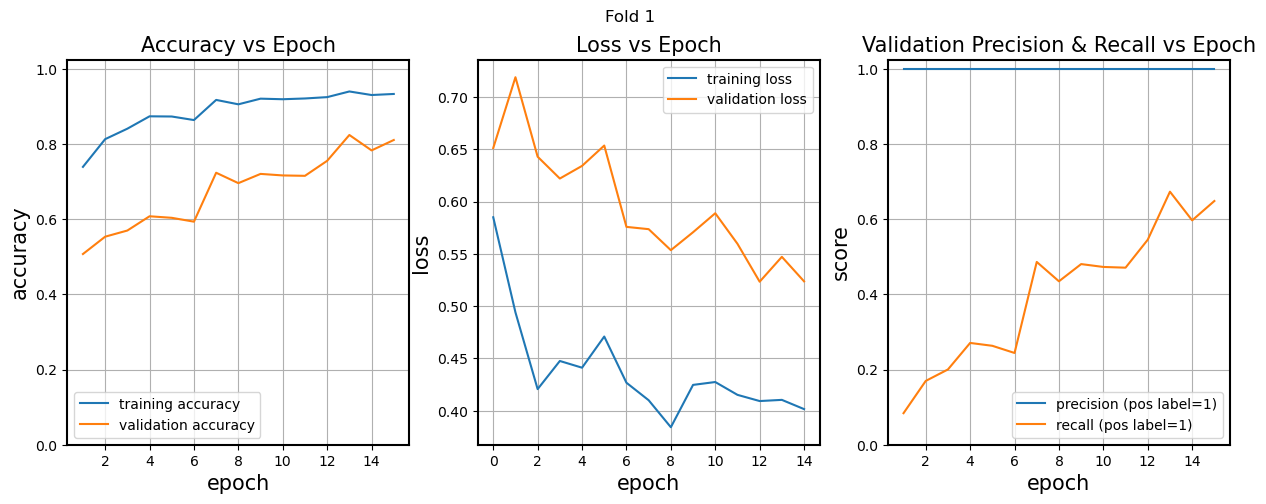

Fold 1 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.744% (524 / 975); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.066% (2195 / 3915); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


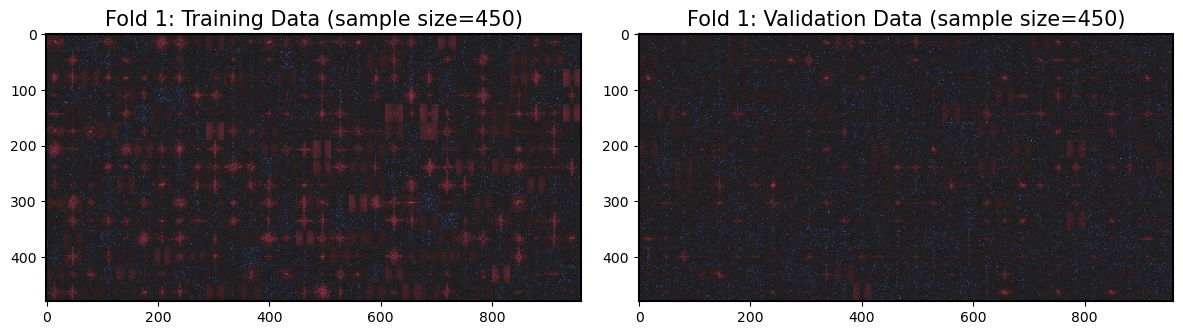

Doing Fold 2 of 6


Epoch 1


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.8183,  acc = 455/975 (46.67%) 
      Train: 	loss = 0.6849,  acc = 1535/2940 (52.21%)


Epoch 2


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.7451,  acc = 457/975 (46.87%) 
      Train: 	loss = 0.5751,  acc = 2170/2940 (73.81%)


Epoch 3


  0%|          | 0/46 [00:00<?, ?batches/s]

       Val: 	loss = 0.7067,  acc = 465/975 (47.69%) 
      Train: 	loss = 0.4924,  acc = 2500/2940 (85.03%)


Epoch 4


  0%|          | 0/46 [00:00<?, ?batches/s]

Keyboard Interrupt: Stopping training
Fold 2 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.846% (525 / 975); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.463% (1660 / 2940); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
Average validation accuracy: 0.7782564102564102
Error in callback <function flush_figures at 0x311e97430> (for post_execute):


KeyboardInterrupt: 

In [329]:
validation_accuracies, trainers = do_cross_validation(test_prop, nfolds)

In [338]:
# Train full model

test_prop = 0.3
nfolds = 1
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 128

test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=0, nfolds=nfolds
)

# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]


print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))




# Training config
learning_rate = 0.001
weight_decay = 1e-5
epochs = 30
gamma = 0.9
# momentum=0.9

model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True,
    # img_type=img_type
);
gc.collect();


test_prop (of dataset) = 33.34%
train_prop (of trainset)= 88.98%
val_prop (of trainset) = 11.02%
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 49.141% (286 / 582); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.712% (2619 / 4701); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.11016467915956843
0
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 48, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 48, 32, 32]          480
|    └─ReLU: 2-2                         [-1, 48, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 48, 32, 32]          96
|    └─Dropout2d: 2-4                    [-1, 48, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 48, 32, 32]          6,960
|    └─ReLU: 2-6                         [-1, 48, 32, 32]          --
|



Epoch 1


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.7021,  acc = 296/582 (50.86%) 



Epoch 2


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6970,  acc = 298/582 (51.20%) 



Epoch 3


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6981,  acc = 297/582 (51.03%) 



Epoch 4


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6969,  acc = 304/582 (52.23%) 



Epoch 5


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6964,  acc = 307/582 (52.75%) 



Epoch 6


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6800,  acc = 317/582 (54.47%) 



Epoch 7


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6884,  acc = 312/582 (53.61%) 



Epoch 8


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6865,  acc = 316/582 (54.30%) 



Epoch 9


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6756,  acc = 328/582 (56.36%) 



Epoch 10


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6701,  acc = 328/582 (56.36%) 



Epoch 11


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6654,  acc = 338/582 (58.08%) 



Epoch 12


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6439,  acc = 353/582 (60.65%) 



Epoch 13


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6550,  acc = 349/582 (59.97%) 



Epoch 14


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6405,  acc = 352/582 (60.48%) 



Epoch 15


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.6067,  acc = 378/582 (64.95%) 



Epoch 16


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5625,  acc = 465/582 (79.90%) 



Epoch 17


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5834,  acc = 435/582 (74.74%) 



Epoch 18


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5570,  acc = 497/582 (85.40%) 



Epoch 19


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5529,  acc = 501/582 (86.08%) 



Epoch 20


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5346,  acc = 534/582 (91.75%) 



Epoch 21


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5328,  acc = 533/582 (91.58%) 



Epoch 22


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5018,  acc = 549/582 (94.33%) 



Epoch 23


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5115,  acc = 546/582 (93.81%) 



Epoch 24


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5066,  acc = 538/582 (92.44%) 



Epoch 25


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4796,  acc = 551/582 (94.67%) 



Epoch 26


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.5021,  acc = 541/582 (92.96%) 



Epoch 27


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4781,  acc = 554/582 (95.19%) 



Epoch 28


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4903,  acc = 550/582 (94.50%) 



Epoch 29


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4927,  acc = 544/582 (93.47%) 



Epoch 30


  0%|          | 0/37 [00:00<?, ?batches/s]

       Val: 	loss = 0.4762,  acc = 553/582 (95.02%) 

Done training


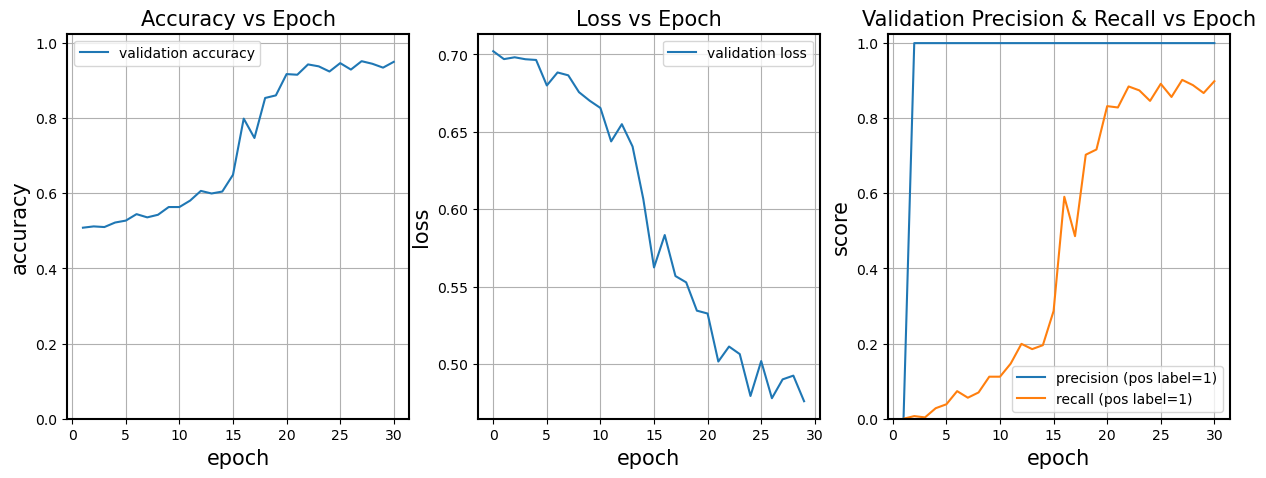

In [339]:
trainer.train(make_train_logs=False)

  0%|          | 0/23 [00:00<?, ?batches/s]

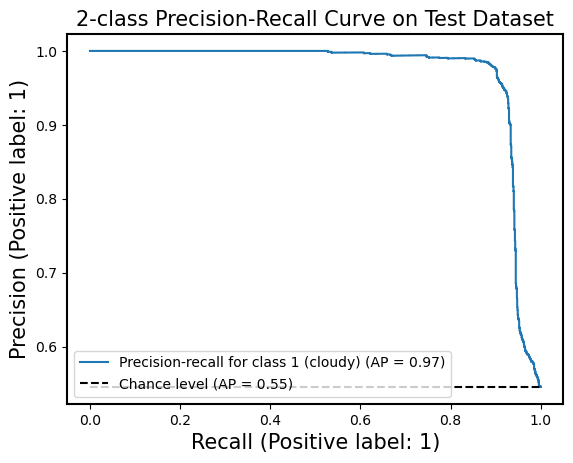

Test: 	loss = 0.4603,  acc = 2587/2934 (88.17%)


In [341]:
test_model = CloudDetection()
test_model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth', weights_only=True))
loss_fn = nn.CrossEntropyLoss()
tester = Tester(test_model, loss_fn, test_loader)
tester.eval()

In [ ]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()